# Anime Recommendation System Project

## Imported Libraries

#### Common Data Science Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### Surprise Libary (for SVD and KNN models)

In [2]:
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD
from surprise import accuracy
from surprise import Reader
from surprise import Dataset

#### User-Defined Libraries

In [3]:
import finalprojutils

## Data Preprocessing

#### Main Anime Dataset (anime.csv)

In [4]:
anime_df = pd.read_csv("data/anime.csv")


print(anime_df.shape)
print(anime_df.columns.unique())
anime_df.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170,182126,131625,62330,20688,8904,3184,1357,741,1580
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,1-Sep-01,Unknown,...,30043,49201,49505,22632,5805,1877,577,221,109,379
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229,75651,86142,49432,15376,5838,1965,664,316,533
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182,4806,10128,11618,5709,2920,1083,353,164,131
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312,529,1242,1713,1068,634,265,83,50,27


#### Anime Ratings Dataset (rating_complete.csv)

In [5]:
ratings_df = pd.read_csv("data/rating_complete.csv")

print(ratings_df.shape)
print(ratings_df.columns.unique())
ratings_df.head()

(57633278, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


#### Dataset Cleaning

In [6]:
print("Before:")
print(anime_df.shape)
print(ratings_df.shape)

anime_df.dropna(inplace=True)
ratings_df.dropna(inplace=True)

print("\nAfter:")
print(anime_df.shape)
print(ratings_df.shape)

Before:
(17562, 35)
(57633278, 3)

After:
(17562, 35)
(57633278, 3)


#### CSV for mapping Name to ID used by app.py (id_to_name.csv)

In [7]:
name_to_id_df = anime_df[['MAL_ID', 'Name', 'English name']]
name_to_id_df.to_csv('data/id_to_name.csv', index=False)

#### Dictionaries for Anime ID and Name Mappings

In [8]:
rid_to_name, name_to_rid = finalprojutils.read_item_names()

## Data Exploratory Analysis

In [9]:
anime_ratings_counts = ratings_df['anime_id'].value_counts()
print(f'Number of rated anime: {len(anime_ratings_counts)}')
print(f'Total number of anime: {len(anime_df)}')
print(f'Percentage of rated anime: {(len(anime_ratings_counts) / len(anime_df) * 100):.2f}%')

Number of rated anime: 16872
Total number of anime: 17562
Percentage of rated anime: 96.07%


Rating Counts:


8     14642156
7     13325549
9      9773857
6      6849293
10     6716048
5      3436250
4      1455102
3       696048
2       405556
1       333419
Name: rating, dtype: int64

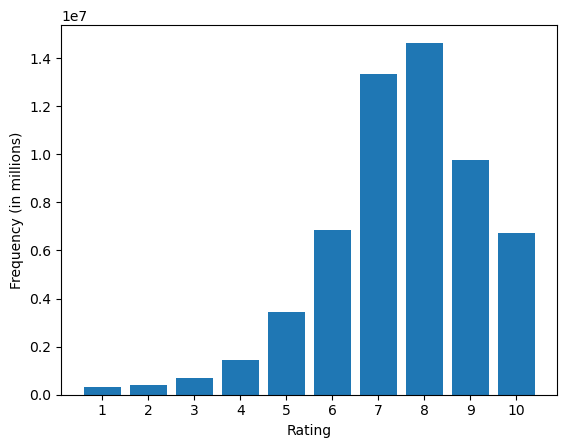

In [10]:
rating_values = ratings_df['rating'].unique()
rating_counts = ratings_df['rating'].value_counts()
plt.bar(rating_counts.index, rating_counts)
plt.xlabel("Rating")
plt.xticks(rating_values)
plt.ylabel("Frequency (in millions)")

print("Rating Counts:")
rating_counts

In [11]:
# returns bounds to be considered outlier for a distribution based on IQR method
def iqr_bounds(value_counts):
    quartiles = np.percentile(value_counts, [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower = quartiles[0] - 1.5 * iqr
    upper = quartiles[2] + 1.5 * iqr
    return lower, upper

# plots both a histogram and boxplot for user ratings per anime and user in a 4x4 grid
# contains an outliers parameter to keep/remove outliers from the distribution
def plot_distributions(df, outliers):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.tight_layout(pad=5)

    x_labels = ["Ratings Count Per Anime", "Ratings Count Per User"]

    for idx, column in enumerate(['anime_id', 'user_id']):
        value_counts = df[column].value_counts()
        lower, upper = iqr_bounds(value_counts)

        if not outliers:
            value_counts = value_counts[(value_counts >= lower) & (value_counts <= upper)]

        axs[0, idx].hist(value_counts, bins=50, edgecolor = "black")
        axs[0, idx].set_xlabel(x_labels[idx])
        axs[0, idx].set_ylabel("Frequency")

        axs[1, idx].boxplot(value_counts, vert=False)
        axs[1, idx].set_xlabel(x_labels[idx])
        axs[1, idx].set_yticks([])

#### Ratings Distributions with Outliers

In [12]:
population_counts_stats = pd.concat([ratings_df['anime_id'].value_counts().describe(),
                                     ratings_df['user_id'].value_counts().describe()],
                                     axis=1)
population_counts_stats.columns = ['Rating Count/Anime', 'Rating Count/User']
population_counts_stats

,Rating Count/Anime,Rating Count/User
count,16872.000000,310059.000000
mean,3415.912636,185.878423
std,10304.206874,255.290522
min,1.000000,1.000000
25%,40.000000,43.000000
50%,266.000000,113.000000
75%,1671.250000,238.000000
max,182375.000000,15455.000000


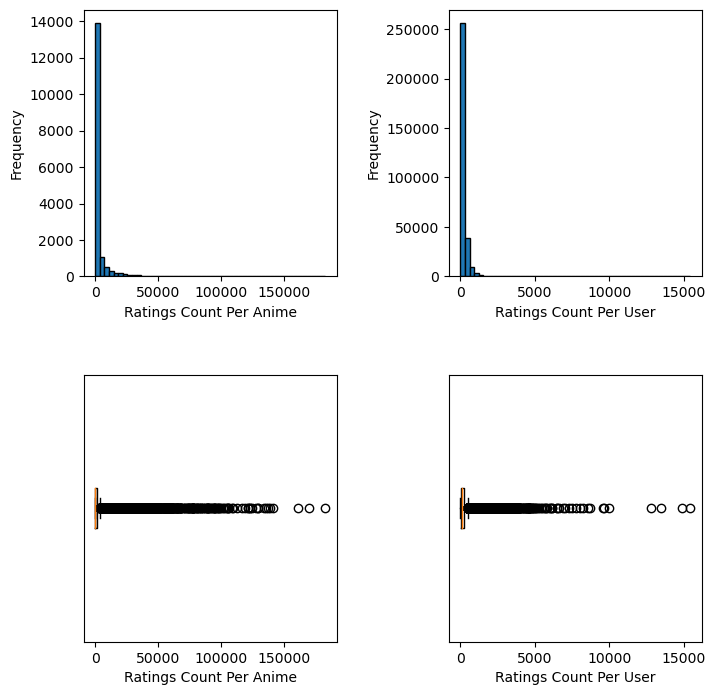

In [13]:
plot_distributions(ratings_df, outliers=True)

#### Ratings Distributions without Outliers

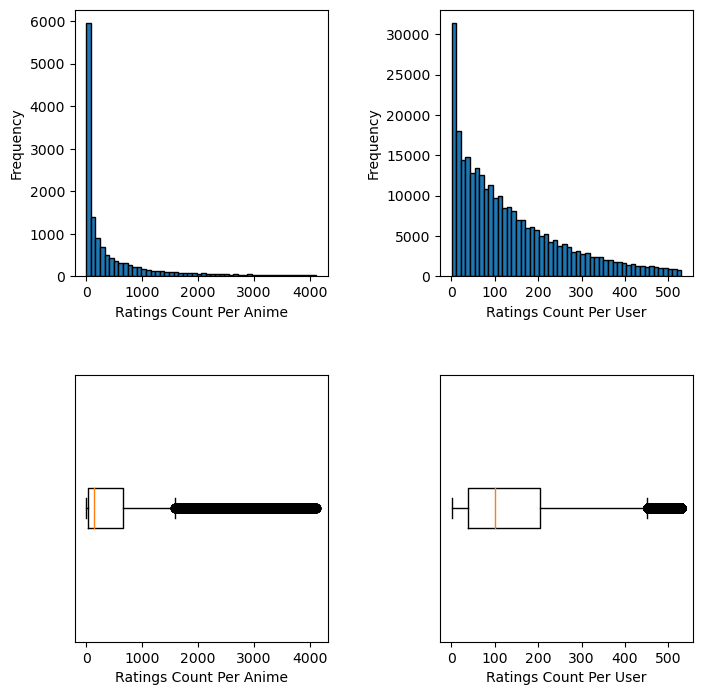

In [14]:
plot_distributions(ratings_df, outliers=False)

#### Ratings Random Sample

In [15]:
# From a dataframe sample all the ratings from N random users, using 'User ID'
def sample_n_user_ratings(source_df, n):
    users = source_df['user_id'].unique()
    user_id_set = set(np.random.choice(users, size=n, replace=False))

    result_df = source_df[source_df['user_id'].isin(user_id_set)].copy()
    
    return result_df

ratings_sample = sample_n_user_ratings(ratings_df, 2000)

In [16]:
sample_counts_stats = pd.concat([ratings_sample['anime_id'].value_counts().describe(),
                                 ratings_sample['user_id'].value_counts().describe()],
                                 axis=1)
sample_counts_stats.columns = ['Rating Count/Anime', 'Rating Count/User']
sample_counts_stats

,Rating Count/Anime,Rating Count/User
count,10110.000000,2000.000000
mean,36.472107,184.366500
std,82.919354,245.986369
min,1.000000,1.000000
25%,2.000000,42.000000
50%,7.000000,117.000000
75%,30.000000,248.000000
max,1149.000000,4598.000000


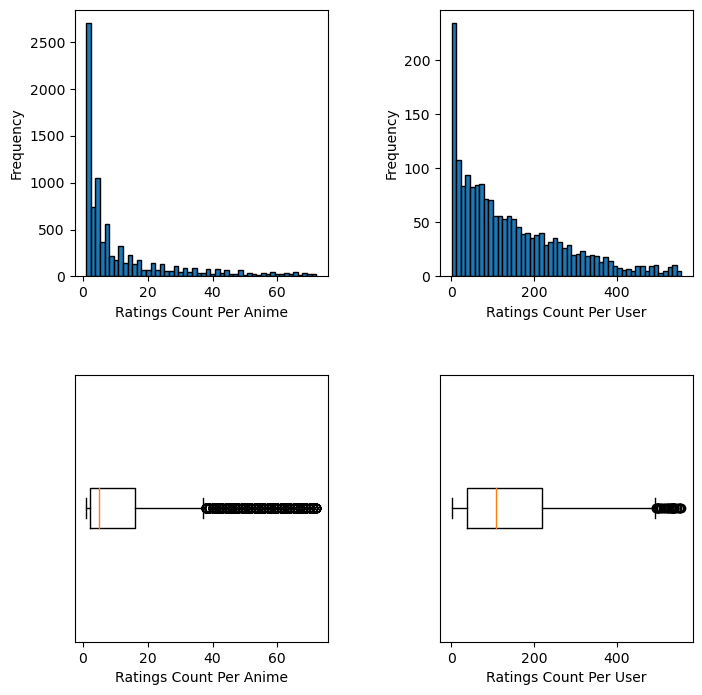

In [17]:
plot_distributions(ratings_sample, outliers=False)

#### Ratings Sample CSV File (frontend_ratings_sample.csv)

In [18]:
# Save as file for frontend usage
ratings_sample.to_csv('data/frontend_ratings_sample.csv', index=False)

## Singular Value Decomposition (SVD)

Data Setup

In [19]:
svd_ratings_dataset = finalprojutils.create_dataset_from_df(ratings_sample)

Grid Search

In [20]:
# Grid search for optimal hyperparameters
param_grid = {
    'lr_all' : [.01],
    'n_factors' : [10, 25, 50, 75, 100],
    'reg_all': [.1],
    'n_epochs' : [25, 50, 100]
}
gridsearch_svd = GridSearchCV(
    SVD, 
    param_grid = param_grid, 
    n_jobs = -1, 
    joblib_verbose = 3)

gridsearch_svd.fit(svd_ratings_dataset)

print(gridsearch_svd.best_score)
print(gridsearch_svd.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:  4.8min remaining:   20.5s


{'rmse': 1.199892756758173, 'mae': 0.9020341514852778}
{'rmse': {'lr_all': 0.01, 'n_factors': 100, 'reg_all': 0.1, 'n_epochs': 25}, 'mae': {'lr_all': 0.01, 'n_factors': 100, 'reg_all': 0.1, 'n_epochs': 25}}


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.6min finished


Index(['split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse',
       'split3_test_rmse', 'split4_test_rmse', 'mean_test_rmse',
       'std_test_rmse', 'rank_test_rmse', 'split0_test_mae', 'split1_test_mae',
       'split2_test_mae', 'split3_test_mae', 'split4_test_mae',
       'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'mean_fit_time',
       'std_fit_time', 'mean_test_time', 'std_test_time', 'params',
       'param_lr_all', 'param_n_factors', 'param_reg_all', 'param_n_epochs'],
      dtype='object')


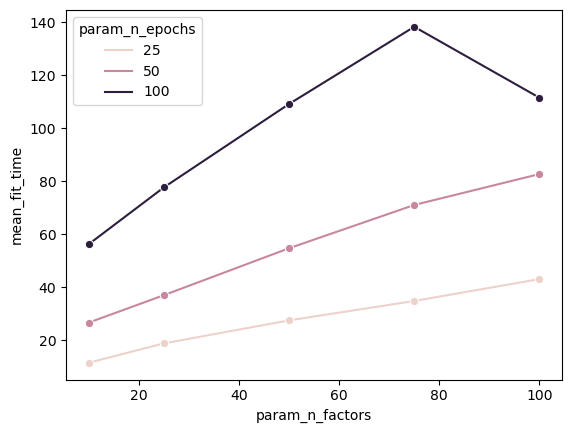

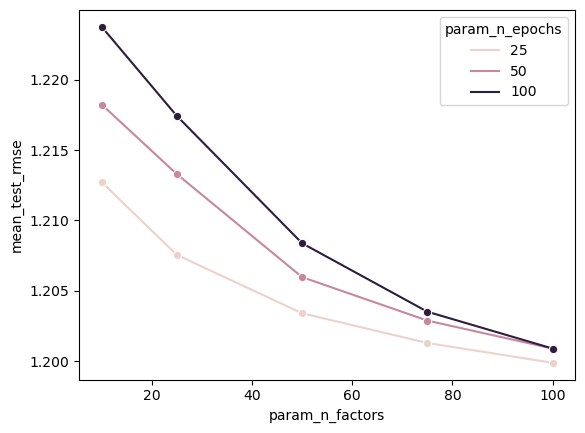

In [21]:
gs_results_df = pd.DataFrame.from_dict(gridsearch_svd.cv_results)

print(gs_results_df.columns)
# Train time for different n factors (embedding size)
sns.lineplot(x='param_n_factors', y='mean_fit_time', hue='param_n_epochs', data=gs_results_df, marker='o')
plt.show()

# RMSE for different n factors
sns.lineplot(x='param_n_factors', y='mean_test_rmse', hue='param_n_epochs', data=gs_results_df, marker='o')
plt.show()

In [22]:
# Create model instance from grid search optimal hyperparameters
svd_instance = gridsearch_svd.best_estimator["rmse"]
# Print Params
print(svd_instance.__dict__)

{'n_factors': 100, 'n_epochs': 25, 'biased': True, 'init_mean': 0, 'init_std_dev': 0.1, 'lr_bu': 0.01, 'lr_bi': 0.01, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_bu': 0.1, 'reg_bi': 0.1, 'reg_pu': 0.1, 'reg_qi': 0.1, 'random_state': None, 'verbose': False, 'bsl_options': {}, 'sim_options': {'user_based': True}}


#### Recommendations with SVD Model

In [23]:
# Create predictions for a mew user provided their anime ratings
# This refits the entire model with the new user appended onto the base df with a user ID of -1

def create_predictions_for_user(model_instance, base_train_df, anime_ids, ratings):

    # Create suprise dataset with new user
    predict_dataset = finalprojutils.create_predict_dataset(
        base_train_df, 
        anime_ids,
        ratings)

    # Retrain
    model_instance.fit(predict_dataset.build_full_trainset())

    # Generate predictions
    print("Generating Anime IDs")
    predict_anime_ids = list(rid_to_name)

    # Remove user provided ids from being predicted
    predict_anime_ids = [int(id) for id in predict_anime_ids if int(id) not in anime_ids]
    predict_anime_ids = pd.unique(predict_anime_ids)

    print("Getting Predictions")
    # Generate and return predictions for all the anime
    return finalprojutils.get_predictions(model_instance, -1, predict_anime_ids)

def create_predictions_for_new_user(model_instance, base_train_df, anime_ids, ratings, print_top_25 = True):
# No randomness between each fit
    model_instance.random_state = 1

    user_1_predictions = create_predictions_for_user(
        model_instance,
        base_train_df,
        anime_ids,
        ratings
        )

    # Print predictions
    if print_top_25:
        print(finalprojutils.get_top_n_string(user_1_predictions, 25, rid_to_name))

In [24]:
# User 1 
# Drama / romance
user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

create_predictions_for_new_user(svd_instance, ratings_sample, user_1_anime_ids, user_1_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. GintamaÂ° (28977) - 9.1034
2. Gintama': Enchousen (15417) - 9.0298
3. Senki Zesshou Symphogear XV (32843) - 8.9798
4. Gintama. (34096) - 8.9687
5. Gintama (918) - 8.9195
6. Gintama' (9969) - 8.9133
7. Kizumonogatari III: Reiketsu-hen (31758) - 8.8943
8. Mahou Shoujo Lyrical Nanoha: The Movie 2nd A's (10153) - 8.854
9. Steins;Gate (9253) - 8.8516
10. Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai (38329) - 8.8463
11. Sora yori mo Tooi Basho (35839) - 8.8424
12. Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare (15335) - 8.8405
13. Girls & Panzer Movie (18617) - 8.8375
14. Gintama.: Shirogane no Tamashii-hen (36838) - 8.8098
15. Aria the Origination (3297) - 8.7706
16. Koe no Katachi (28851) - 8.7662
17. JoJo no Kimyou na Bouken Part 5: Ougon no Kaze (37991) - 8.763
18. Gintama Movie 1: Shinyaku Benizakura-hen (7472) - 8.7587
19. 3-gatsu no Lion 2nd Season (35180) - 8.7545
20. Owarimonogatari 2nd Season (3524

In [25]:
# User 2 
# Action / Adventure
user_2_anime_ids = [114, 31964, 32051, 34134, 38000]
user_2_ratings = [9, 10, 8, 9, 9]

create_predictions_for_new_user(svd_instance, ratings_sample, user_2_anime_ids, user_2_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. GintamaÂ° (28977) - 9.7667
2. Gintama. (34096) - 9.7477
3. Gintama (918) - 9.6274
4. Gintama' (9969) - 9.6076
5. Hunter x Hunter (2011) (11061) - 9.601
6. Kimi no Na wa. (32281) - 9.584
7. Gintama': Enchousen (15417) - 9.5709
8. Steins;Gate (9253) - 9.5395
9. Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare (15335) - 9.5273
10. Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou (32935) - 9.5271
11. Fullmetal Alchemist: Brotherhood (5114) - 9.5253
12. Ginga Eiyuu Densetsu (820) - 9.5236
13. Shingeki no Kyojin Season 3 Part 2 (38524) - 9.5085
14. 3-gatsu no Lion 2nd Season (35180) - 9.4938
15. Senki Zesshou Symphogear XV (32843) - 9.4896
16. Gintama.: Shirogane no Tamashii-hen - Kouhan-sen (37491) - 9.4891
17. Mushishi Zoku Shou 2nd Season (24701) - 9.4807
18. Mushishi (457) - 9.4795
19. Haikyuu!! Second Season (28891) - 9.4596
20. JoJo no Kimyou na Bouken Part 5: Ougon no Kaze (37991) - 9.4565
21. Ashita no

In [26]:
# User 3 
# Boys Love
user_3_anime_ids = [114, 31964, 32051, 34134, 38000, 39533, 30346, 44055, 918]
user_3_ratings = [4, 5, 4, 6, 4, 10, 10, 9, 4]

create_predictions_for_new_user(svd_instance, ratings_sample, user_3_anime_ids, user_3_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. Ashita no Joe 2 (2921) - 8.2222
2. Haibane Renmei (387) - 8.1765
3. Mawaru Penguindrum (10721) - 7.9081
4. Tengen Toppa Gurren Lagann (2001) - 7.8427
5. Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen (33095) - 7.7889
6. Senki Zesshou Symphogear XV (32843) - 7.7658
7. Planetes (329) - 7.7622
8. Natsume Yuujinchou Movie: Utsusemi ni Musubu (36538) - 7.7315
9. Koukaku Kidoutai: Stand Alone Complex (467) - 7.727
10. Aria the Origination (3297) - 7.7058
11. Ginga Eiyuu Densetsu (820) - 7.6942
12. Clannad: After Story (4181) - 7.687
13. Mushishi Zoku Shou 2nd Season (24701) - 7.6655
14. Maison Ikkoku (1453) - 7.6635
15. Neon Genesis Evangelion (30) - 7.648
16. Aria the OVA: Arietta (2563) - 7.6311
17. Sarazanmai (37426) - 7.6181
18. Uchuu Senkan Yamato 2199 (12029) - 7.6074
19. Shinsekai yori (13125) - 7.6008
20. Kino no Tabi: The Beautiful World (486) - 7.5992
21. Gintama. (34096) - 7.5947
22. Aria the Origination: So

#### Training/Predict Time With Scaling User Count

Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions


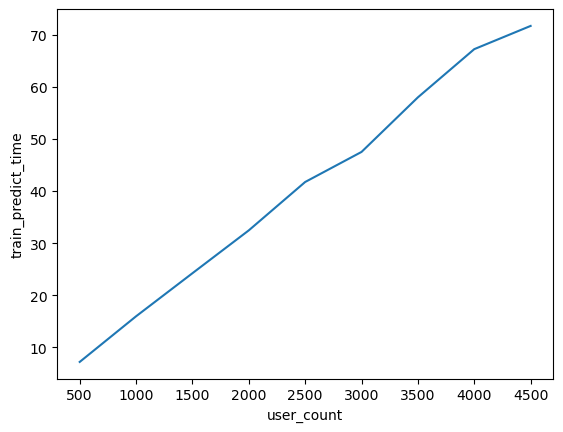

In [27]:
import time
user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

def plot_training_times(low, high, step, model_instance, anime_ids, ratings):
    train_times = pd.DataFrame(columns = ['user_count', 'train_predict_time'])

    for i in range(low, high, step):
        test_ratings_sample = sample_n_user_ratings(ratings_df, i)
        start = time.time()
        create_predictions_for_new_user(model_instance, test_ratings_sample, anime_ids, ratings, False)
        end = time.time()
        elapsed = end - start
        train_times.loc[len(train_times)] = [i, elapsed]
        # print(f'sample of {i} users took {elapsed} seconds to train and predict a new user')

    sns.lineplot(x='user_count', y='train_predict_time', data=train_times, markers='o')
    plt.show()

test_instance = SVD(lr_all = 0.01, n_factors = 100, reg_all = 0.1, n_epochs = 50)
plot_training_times(500, 5000, 500, test_instance, user_1_anime_ids, user_1_ratings)

## K-Nearest Neighbors (KNN)

#### Loading Sample into Dataset

In [28]:
reader = Reader(rating_scale=(1,10))
knn_data = Dataset.load_from_df(ratings_sample, reader)
knn_data

#### KNN Basic

In [29]:
knn_basic_algo = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_basic = cross_validate(knn_basic_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_basic

avg_rmse_basic = np.mean(cv_knn_basic['test_rmse'])
avg_mae_basic = np.mean(cv_knn_basic['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_basic, 4))
print("Average MAE:", round(avg_mae_basic, 4))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5630  1.5512  1.5576  1.5619  1.5695  1.5606  0.0060  
MAE (testset)     1.1929  1.1821  1.1850  1.1893  1.1919  1.1882  0.0041  
Fit time          5.59    5.48    5.58    5.63    5.54    5.56    0.05    
Test time         8.34    8.04    8.12    8.01    7.92    8.08    0.14    

Average RMSE: 1.5606
Average MAE: 1.1882


#### KNN Baseline

In [30]:
knn_baseline_algo = KNNBaseline(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_baseline = cross_validate(knn_baseline_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_baseline

avg_rmse_baseline = np.mean(cv_knn_baseline['test_rmse'])
avg_mae_baseline = np.mean(cv_knn_baseline['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_baseline, 4))
print("Average MAE:", round(avg_mae_baseline, 4))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2650  1.2679  1.2620  1.2673  1.2618  1.2648  0.0025  
MAE (testset)     0.9523  0.9569  0.9467  0.9560  0.9499  0.9524  0.0038  
Fit time          6.09    6.01    6.61    6.06    6.00    6.16    0.23    
Test time         8.55    9.59    8.87    8.64    8.86    8.90    0.37    

Average RMSE: 1.2648
Averag

#### KNN With Means

In [31]:
knn_means_algo = KNNWithMeans(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_means = cross_validate(knn_means_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_means

avg_rmse_means = np.mean(cv_knn_means['test_rmse'])
avg_mae_means = np.mean(cv_knn_means['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_means, 4))
print("Average MAE:", round(avg_mae_means, 4))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3105  1.3105  1.3106  1.3007  1.3055  1.3076  0.0039  
MAE (testset)     0.9969  0.9933  0.9953  0.9905  0.9948  0.9942  0.0022  
Fit time          5.97    6.56    5.66    6.05    5.70    5.99    0.32    
Test time         9.25    8.62    8.39    8.22    9.02    8.70    0.39    

Average RMSE: 1.3076
Average MAE: 0.9942


#### Best KNN Model

In [32]:
best_knn_algo = None
best_knn_rmse = np.min([avg_rmse_basic, avg_rmse_baseline, avg_rmse_means])
best_knn_mae = np.min([avg_mae_basic, avg_mae_baseline, avg_mae_means])
best_algo_type = ""

if best_knn_rmse == avg_rmse_basic:
    best_algo_type = "KNN Basic"
    best_knn_algo = knn_basic_algo
elif best_knn_rmse == avg_rmse_baseline:
    best_algo_type = "KNN Baseline"
    best_knn_algo = knn_baseline_algo
else:
    best_algo_type = "KNN With Means"
    best_knn_algo = knn_means_algo

print("Best KNN Algorithm:", best_algo_type)
print("Best Average RMSE:", round(best_knn_rmse, 4))
print("Best Average MAE:", round(best_knn_mae, 4))

knn_rmses_df = pd.DataFrame({'KNN Basic': [avg_rmse_basic, avg_mae_basic],
                             'KNN Baseline': [avg_rmse_baseline, avg_mae_baseline],
                             'KNN With Means': [avg_rmse_means, avg_mae_means]})
knn_rmses_df.index = ['Average RMSE', 'Average MAE']
knn_rmses_df

Best KNN Algorithm: KNN Baseline
Best Average RMSE: 1.2648
Best Average MAE: 0.9524


,KNN Basic,KNN Baseline,KNN With Means
Average RMSE,1.560643,1.264786,1.307557
Average MAE,1.188233,0.952398,0.994161


#### Recommendations with KNN

In [34]:
# model input is a single anime, output is k nearest animes
anime_name = "Cowboy Bebop"

# anime name must be mapped to id for model
anime_raw_id = int(name_to_rid[anime_name.lower()])
anime_inner_id = best_knn_algo.trainset.to_inner_iid(anime_raw_id)

anime_neighbors = best_knn_algo.get_neighbors(anime_inner_id, k=10)

# print recommendations
print("The 10 nearest neighbors of", anime_name, "are:")
for inner_id in anime_neighbors:
    print(rid_to_name[str(best_knn_algo.trainset.to_raw_iid(inner_id))])

The 10 nearest neighbors of Cowboy Bebop are:
Charlotte
Tekken: Blood Vengeance
Yuri!!! on Ice
ACCA: 13-ku Kansatsu-ka
Angel Beats!
Inu to Hasami wa Tsukaiyou
Fullmetal Alchemist: Brotherhood Specials
Denpa Kyoushi (TV)
Yami to Boushi to Hon no Tabibito
Aki-Sora


## Exported Models for Front-end

In [35]:
import pickle

pickle.dump(best_knn_algo, open('knn_model.pkl','wb'))
pickle.dump(svd_instance, open('svd_model.pkl','wb'))